# Arabic Sentiment Classifier

> Updating `nltk` to use ArabicStemmer
>
> Fetching [ASTD](https://www.mohamedaly.info/datasets/astd) dataset


In [1]:
!python3 -m pip install --upgrade nltk

!git clone "https://github.com/mahmoudnabil/ASTD.git"


     |████████████████████████████████| 1.5 MB 241 kB/s            
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.7 which is incompatible.
allennlp 2.9.0 requires nltk<3.6.6, but you have nltk 3.7 which is incompatible.
Cloning into 'ASTD'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), 558.02 KiB | 598.00 KiB/s, done.


---

## Importing modules & defining globals


In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import re
import tensorflow as tf
from nltk.corpus import stopwords

try:
    from nltk.stem.snowball import SnowballStemmer, ArabicStemmer
except Exception:
    from nltk.stem.snowball import SnowballStemmer

    def ArabicStemmer(*args, **kwargs):
        """A wrapper for SnowballStemmer w/ Arabic for nltk < 3.7

        FIXME
        """
        return SnowballStemmer(*(("arabic",) + args), **kwargs)


from nltk.stem.isri import ISRIStemmer

# from nltk.stem.arlstem import ARLSTem
from nltk.stem.arlstem2 import ARLSTem2
from pylab import rcParams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from typing import Callable, Union

STOP_WORDS = stopwords.words("arabic")
rcParams["figure.figsize"] = (16, 9)


---

## Loading dataset


In [3]:
corpus = []
for line in open("./ASTD/data/Tweets.txt"):
    line = line.strip()
    corpus.append(line.split("\t"))

df = pd.DataFrame(corpus, columns=["tweet", "sentiment"])
df.drop_duplicates(inplace=True)
# df["sentiment"] = df["sentiment"].replace({"POS":"HPY", "NEG":"SAD", "NEUTRAL":"NTR"})
df["sentiment"] = df["sentiment"].astype("category")


In [4]:
df.describe()


,tweet,sentiment
count,10002,10002
unique,10002,4
top,بعد استقالة رئيس #المحكمة_الدستورية ننتظر استق...,OBJ
freq,1,6687


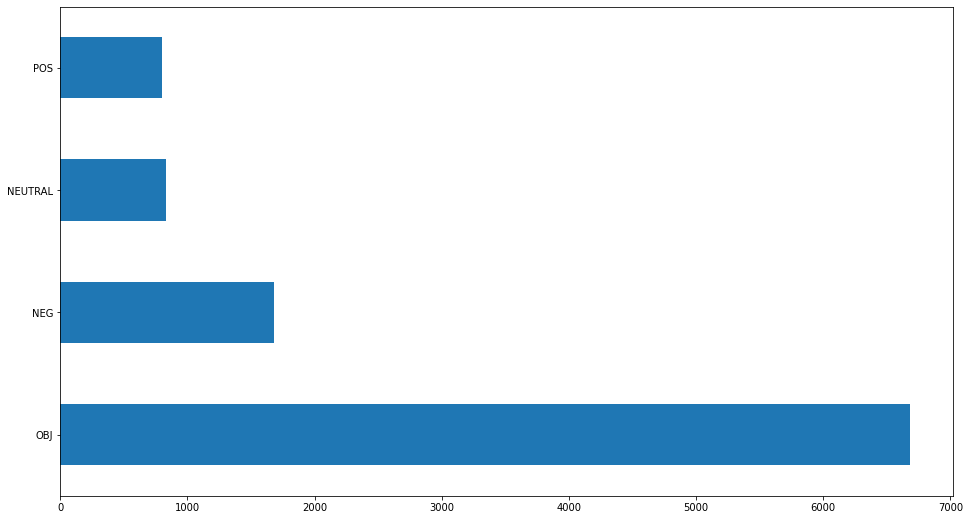

In [5]:
df["sentiment"].value_counts().plot.barh()
plt.show()


> keeping a portion as a validation set


In [6]:
df, valid = train_test_split(
    df, test_size=0.15, random_state=42, stratify=df["sentiment"]
)
pickle.dump(valid, open("valid.pkl", "wb"))
del valid


---

## Preprocessing


In [7]:
RE_HANDLE = r"\b@\w+\b"
RE_URI = r"\bhttps?://\S+\b"
# to capture letters that repeat over 3 times
RE_CHAR_3_PLUS = r"(?u)(?=(\w))\1{3,}"

# to capture most common arabic glyphs
RE_RANGE_ARA = r"\ufe70-\ufefc\u0621-\u063a\u0640-\u0652\u060c\u061f"
RE_NOT_ARA = r"(?u)\b[^" + RE_RANGE_ARA + "]+\b"

# converting farsi glyphs into arabic
RE_NORMALISE = {
    RE_HANDLE: " ",
    RE_URI: " ",
    RE_NOT_ARA: " ",
    RE_CHAR_3_PLUS: r"\1\1",
    r"(?u)[\d\s_]+": r" ",
    r"\u06fd": "\u0621",
    r"[\u0676\u0677]": "\u0624",
    r"[\u0678\u06d3]": "\u0626",
    r"[\u0622\u0623\u0625\u0671-\u0675]": "\u0627",
    r"[\u067b\u067e\u0680]": "\u0628",
    r"[\u067a\u067c\u067d\u067f]": "\u062a",
    r"[\u0686\u0687]": "\u062c",
    r"[\u0688-\u068b\u068d]": "\u062f",
    r"[\u068c\u068e-\u0690]": "\u0630",
    r"[\u066b\u0691-\u0695]": "\u0631",
    r"[\u0696-\u0699]": "\u0632",
    r"[\u069a\u069b]": "\u0633",
    r"\u069c": "\u0634",
    r"\u060f": "\u0639",
    r"\u06d4": "\u0640",
    r"[\u06a4\u06a5]": "\u0641",
    r"\u06a8\u06a6": "\u0642",
    r"[\u063b\u063c\u06a9-\u06b4]": "\u0643",
    r"[\u06b5-\u06b8]": "\u0644",
    r"\u06fe": "\u0645",
    r"[\u06b9-\u06bd]": "\u0646",
    r"[\u0629\u06be\u06c0-\u06c3\u06ff]": "\u0647",
    r"[\u06c4-\u06cb\u06cf]": "\u0648",
    r"[\u0620\u063d-\u063f\u0649\u06cc-\u06ce\u06d0-\u06d2\u06e6\u06e7]": "\u064a",
    r"[\u06d9\ufef5\ufef7\ufef9]": "\ufefb",
}


In [8]:
def preprocess(
    corpus: Union[list, np.ndarray, pd.Series], stemmer: Callable = None
) -> np.ndarray:
    """preprocessing the `corpus`, by normalising the Arabic characters,
    removing non-Arabic glyphs, and dropping Twitter-specific features

    Parameters:
    -----------
    corpus: list, numpy.ndarray, pandas.Series
        the tweets given in array-like form to be preprocessed
    stemmer: function (optional)
        optional stem method of any of nltk's Arabic stemmers

    Returns:
    --------
    out: numpy.ndarray
        the preprocessed tweets
    """
    corpus = pd.Series(corpus, dtype=str)
    for pattern, repl in RE_NORMALISE.items():
        corpus = corpus.apply(lambda s: re.sub(pattern, repl, s))

    if stemmer:
        corpus = corpus.apply(stemmer)
    return corpus.values


In [9]:
STOP_WORDS = preprocess(STOP_WORDS).tolist()


---

## Model selection & training


In [10]:
arstem = ArabicStemmer().stem
isrstem = ISRIStemmer().stem
arlstem = ARLSTem2().stem

corpus = df["tweet"]
labels = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    corpus, labels, random_state=42, test_size=0.2, stratify=labels
)


In [11]:
h_params = {
    "vectoriser__analyzer": ["word", "char", "char_wb"],
    "vectoriser__ngram_range": [(1, 1), (2, 7)],
    "clf__alpha": np.arange(0.05, 0.55, 0.05),
}

pi_cv_nb = Pipeline(
    [("vectoriser", CountVectorizer(stop_words=STOP_WORDS)), ("clf", MultinomialNB())]
)
pi_ti_nb = Pipeline(
    [("vectoriser", TfidfVectorizer(stop_words=STOP_WORDS)), ("clf", MultinomialNB())]
)


In [ ]:
stems = [arstem, isrstem, arlstem]
train = {}
for i in range(len(stems)):
    train[i] = preprocess(X_train, stems[i])

best_params = {}
for pipe in [pi_cv_nb, pi_ti_nb]:
    search = RandomizedSearchCV(
        pipe, h_params, random_state=42, cv=5, scoring="f1_micro"
    )
    for i in train:
        search.fit(train[i], y_train)
        best_params[i] = search.best_params_
    print(best_params)


### A benchmark model


In [13]:
benchmark = Pipeline(
    steps=[
        ("vectoriser", TfidfVectorizer(stop_words=STOP_WORDS)),
        ("clf", MultinomialNB(alpha=0.15)),
    ]
)

stemmer = arstem
X_train_stem = preprocess(X_train, stemmer)
scoring = [
    "f1_micro",
    "neg_log_loss",
]


In [14]:
report = cross_validate(benchmark, X_train_stem, y_train, scoring=scoring)
report


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ؤلاء', 'ات', 'اتان', 'اخ', 'ارتد', 'افعل', 'افعله', 'امين', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ؤلاء', 'ات', 'اتان', 'اخ', 'ارتد', 'افعل', 'افعله', 'امين', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)
/opt/conda/lib/python3.7/site-packages/sklearn/feature

{'fit_time': array([0.19428587, 0.1937499 , 0.2077508 , 0.20163298, 0.3761375 ]),
 'score_time': array([0.07767725, 0.08309913, 0.08346415, 0.08053136, 0.07778239]),
 'test_f1_micro': array([0.68088235, 0.675     , 0.68602941, 0.67867647, 0.68455882]),
 'test_neg_log_loss': array([-0.95361406, -0.95013097, -0.9060624 , -0.89811208, -0.94620186])}

### Alternative models


In [15]:
alt_1 = Pipeline(
    [
        (
            "vectoriser",
            TfidfVectorizer(
                ngram_range=(2, 7), analyzer="char_wb", stop_words=STOP_WORDS
            ),
        ),
        ("clf", MultinomialNB(alpha=0.05)),
    ]
)

stemmer = isrstem
X_train_stem = preprocess(X_train, stemmer)


In [16]:
report = cross_validate(alt_1, X_train_stem, y_train, scoring=scoring)
report


{'fit_time': array([2.60207558, 2.55441546, 2.50182223, 2.56090164, 2.4838593 ]),
 'score_time': array([0.91997027, 0.91319323, 0.89832735, 0.88995409, 0.89620924]),
 'test_f1_micro': array([0.69117647, 0.69338235, 0.69191176, 0.7       , 0.68823529]),
 'test_neg_log_loss': array([-1.67917274, -1.61898715, -1.50973468, -1.45764405, -1.62605451])}

In [17]:
alt_2 = Pipeline(
    [
        (
            "vectoriser",
            CountVectorizer(ngram_range=(2, 7), analyzer="char", stop_words=STOP_WORDS),
        ),
        ("clf", MultinomialNB(alpha=0.5)),
    ]
)

stemmer = arstem
X_train_stem = preprocess(X_train, stemmer)


In [18]:
report = cross_validate(alt_2, X_train_stem, y_train, scoring=scoring)
report


{'fit_time': array([5.51183534, 5.59194112, 5.51675272, 5.51439643, 5.6110847 ]),
 'score_time': array([1.28827929, 1.31100893, 1.27562165, 1.33140087, 1.26319933]),
 'test_f1_micro': array([0.69485294, 0.68529412, 0.69044118, 0.69117647, 0.68676471]),
 'test_neg_log_loss': array([-9.4496364 , -9.48623566, -9.35943064, -9.27741376, -9.65058137])}

In [19]:
X_train_stem = preprocess(X_train, arstem)
X_test_stem = preprocess(X_test, arstem)

_ = alt_1.fit(X_train_stem, y_train)


In [20]:
y_pred = alt_1.predict(X_test_stem)

print(classification_report(y_test, y_pred, labels=y_test.unique(), digits=4))


              precision    recall  f1-score   support

         OBJ     0.7108    0.9340    0.8073      1137
         NEG     0.4770    0.2902    0.3609       286
         POS     0.3636    0.0294    0.0544       136
     NEUTRAL     0.2273    0.0352    0.0610       142

    accuracy                         0.6784      1701
   macro avg     0.4447    0.3222    0.3209      1701
weighted avg     0.6034    0.6784    0.6097      1701



- clearly the imbalance greatly affects the metrics


In [21]:
alt_3 = Pipeline(
    [
        (
            "vectoriser",
            TfidfVectorizer(
                ngram_range=(2, 7), analyzer="char_wb", stop_words=STOP_WORDS
            ),
        ),
        (
            "clf",
            SVC(
                kernel="linear",
                probability=True,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

_ = alt_3.fit(X_train_stem, y_train)


In [22]:
y_pred = alt_3.predict(X_test_stem)

print(classification_report(y_test, y_pred, labels=y_test.unique(), digits=4))


              precision    recall  f1-score   support

         OBJ     0.8131    0.7537    0.7823      1137
         NEG     0.4169    0.5524    0.4752       286
         POS     0.3115    0.2794    0.2946       136
     NEUTRAL     0.2671    0.2746    0.2708       142

    accuracy                         0.6420      1701
   macro avg     0.4521    0.4651    0.4557      1701
weighted avg     0.6608    0.6420    0.6490      1701



In [ ]:
for clf in [benchmark, alt_2]:
    _ = clf.fit(X_train_stem, y_train)


In [24]:
# TODO SVC w/ non-linear kernel


---

## A DL approach

### preprocessing for DL


In [25]:
def drop_stopwords_doc(
    document: str, stop_words: Union[list, np.ndarray] = STOP_WORDS
) -> str:
    """removes the stop words from a given document

    Parameters:
    -----------
    document: str
        the string to be cleaned
    stop_words: list, numpy.ndarray
        the list of stop words to compare against

    Returns:
    --------
    out: str
        the string without the stop words
    """
    processed = " ".join([word for word in document.split() if word not in stop_words])
    processed = re.sub(r"\s{2,}", " ", processed)
    return processed


drop_stopwords_corpus = np.vectorize(drop_stopwords_doc)


In [26]:
X_test_stem = preprocess(X_test, arstem)


In [27]:
X_train_nostop = drop_stopwords_corpus(X_train_stem)
X_test_nostop = drop_stopwords_corpus(X_test_stem)


In [28]:
tokeniser = tf.keras.preprocessing.text.Tokenizer()
_ = tokeniser.fit_on_texts(X_train_nostop)
X_train_seq = tokeniser.texts_to_sequences(X_train_nostop)
X_test_seq = tokeniser.texts_to_sequences(X_test_nostop)


In [29]:
MAX_LENGTH = int(1.5 * max([len(seq) for seq in X_train_seq]))
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(
    X_train_seq, MAX_LENGTH, padding="post"
)
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(
    X_test_seq, MAX_LENGTH, padding="post"
)


In [30]:
y_train_cat = y_train.astype("category").cat.codes
y_train_cat = tf.keras.utils.to_categorical(y_train_cat)

y_test_cat = y_test.astype("category").cat.codes
y_test_cat = tf.keras.utils.to_categorical(y_test_cat)


## Model selection

### [Mazajak](http://mazajak.inf.ed.ac.uk:8000/) architecture


In [31]:
input_dim = len(tokeniser.word_counts) + 1

mazaj = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(input_dim, 300, input_length=MAX_LENGTH),
        tf.keras.layers.Conv1D(300, 3, activation="relu"),
        tf.keras.layers.MaxPool1D(),
        tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dense(y_train_cat.shape[1], activation="softmax"),
    ],
    name="mazajak",
)

mazaj.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    "categorical_crossentropy",
    "categorical_accuracy",
)

mazaj.summary()


2022-03-18 21:38:22.187640: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "mazajak"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 300)           7788900   
_________________________________________________________________
conv1d (Conv1D)              (None, 37, 300)           270300    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 8,279,364
Trainable params: 8,279,364
Non-trainable params: 0
_________________________________________________________________


In [32]:
_ = mazaj.fit(
    np.r_[X_train_pad, X_test_pad],
    np.r_[y_train_cat, y_test_cat],
    epochs=2,
    verbose=1,
    validation_split=0.2,
)


2022-03-18 21:38:22.853268: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
213/213 [==============================] - 44s 188ms/step - loss: 0.9988 - categorical_accuracy: 0.6644 - val_loss: 0.9777 - val_categorical_accuracy: 0.6684
Epoch 2/2
213/213 [==============================] - 39s 184ms/step - loss: 0.8700 - categorical_accuracy: 0.6916 - val_loss: 0.9346 - val_categorical_accuracy: 0.6796


### Alternatives

> inspired by [DataCamp](https://www.datacamp.com/courses/recurrent-neural-networks-for-language-modeling-in-python)


In [33]:
alt_4 = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(input_dim, 300, input_length=MAX_LENGTH),
        tf.keras.layers.LSTM(
            128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True
        ),
        tf.keras.layers.LSTM(
            64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False
        ),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(y_train_cat.shape[1], activation="softmax"),
    ],
    name="alt_4",
)

alt_4.compile(
    "adam",
    "categorical_crossentropy",
    "categorical_accuracy",
)

alt_4.summary()


Model: "alt_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 39, 300)           7788900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 39, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 8,060,168
Trainable params: 8,060,168
Non-trainable params: 0
___________________________________________________

In [34]:
_ = alt_4.fit(
    np.r_[X_train_pad, X_test_pad],
    np.r_[y_train_cat, y_test_cat],
    epochs=1,
    verbose=1,
    validation_split=0.2,
)


213/213 [==============================] - 94s 410ms/step - loss: 1.0374 - categorical_accuracy: 0.6590 - val_loss: 0.9292 - val_categorical_accuracy: 0.6684


In [35]:
alt_5 = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(input_dim, 300, input_length=MAX_LENGTH),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False
            )
        ),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(y_train_cat.shape[1], activation="softmax"),
    ],
    name="alt_5",
)

alt_5.compile(
    "adam",
    "categorical_crossentropy",
    "categorical_accuracy",
)

alt_5.summary()


Model: "alt_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 39, 300)           7788900   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 132       
Total params: 8,236,552
Trainable params: 8,236,552
Non-trainable params: 0
_________________________________________________________________


In [36]:
_ = alt_5.fit(
    np.r_[X_train_pad, X_test_pad],
    np.r_[y_train_cat, y_test_cat],
    epochs=1,
    verbose=1,
    validation_split=0.2,
)


213/213 [==============================] - 110s 484ms/step - loss: 0.9797 - categorical_accuracy: 0.6634 - val_loss: 0.9052 - val_categorical_accuracy: 0.6690


---

## Validation


In [37]:
valid = pickle.load(open("valid.pkl", "rb"))
X_valid = valid["tweet"]
y_valid = valid["sentiment"]

X_valid_stem = preprocess(X_valid, arstem)


In [38]:
model_names = ["benchmark", "alt_1", "alt_2", "alt_3"]  # , "mazajak", "alt_4", "alt_5"]
models = [benchmark, alt_1, alt_2, alt_3]  # , model, alt_4, alt_5]
scores = {}


In [39]:
for i in range(4):
    y_pred = models[i].predict(X_valid_stem)
    report = classification_report(y_valid, y_pred, labels=y_valid.unique(), digits=4)
    scores[model_names[i]] = report


In [40]:
X_valid_nostop = drop_stopwords_corpus(X_valid_stem)
X_valid_seq = tokeniser.texts_to_sequences(X_valid_nostop)
X_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(
    X_valid_seq, MAX_LENGTH, padding="post"
)

y_valid_cat = y_valid.astype("category").cat.codes
y_valid_cat = tf.keras.utils.to_categorical(y_valid_cat)

models = [mazaj, alt_4, alt_5]
scoring = ["categorical_crossentropy", "categorical_accuracy"]


In [41]:
for model in models:
    report = model.evaluate(X_valid_pad, y_valid_cat, verbose=0)
    scores[model.name] = dict(zip(scoring, report))


In [42]:
for model_name in scores:
    print(model_name)
    print(scores[model_name])
    print("=" * 88)


benchmark
              precision    recall  f1-score   support

         NEG     0.4177    0.1304    0.1988       253
         OBJ     0.6897    0.9661    0.8048      1003
         POS     0.4286    0.0250    0.0472       120
     NEUTRAL     0.4000    0.0320    0.0593       125

    accuracy                         0.6722      1501
   macro avg     0.4840    0.2884    0.2775      1501
weighted avg     0.5988    0.6722    0.5800      1501

alt_1
              precision    recall  f1-score   support

         NEG     0.5128    0.3162    0.3912       253
         OBJ     0.7212    0.9412    0.8166      1003
         POS     0.4375    0.0583    0.1029       120
     NEUTRAL     0.3500    0.0560    0.0966       125

    accuracy                         0.6915      1501
   macro avg     0.5054    0.3429    0.3518      1501
weighted avg     0.6325    0.6915    0.6279      1501

alt_2
              precision    recall  f1-score   support

         NEG     0.5212    0.3399    0.4115       253